# Multivariate Multistep TimeSeries 실습

- 가구의 Energy 사용량 예측

- Household Power Consumption Dataset 은 한 가구의 4 년간 전력소비를 나타내는 multivariate time series dataset 임

- data 수집기간은 2006 Dec 에서 2010 Nov 까지의 분 단위 관측값 2075259 개로 구성

- variables :  



    - global active power: 가구에서 소비한 총 유효전력 (total active power, kilowatts).
    - global reactive power: 가구에서 소비한 총 무효전력 (total reactive power, kilowatts).
    - voltage: 평균 voltage (volts).
    - global intensity: 평균 전류 밀도 (amps).
    - sub metering 1: 주방에서 사용된 active energy (watt-hours of active energy).
    - sub metering 2: 세탁에 사용된 active energy (watt-hours of active energy).
    - sub metering 3: 공조기 제어 시스템에 사용된 active energy (watt-hours of active energy)
    - sub metering 4: 기타 다른 곳에서 사용된 energy 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
dataset = pd.read_csv("/content/gdrive/MyDrive/household_power_consumption.csv", index_col=0, parse_dates=True)
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [6]:
print(dataset.shape)
print()
print(dataset.info())
print()
print(dataset.isna().sum())

(2075259, 8)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   Sub_metering_4         float64
dtypes: float64(8)
memory usage: 142.5 MB
None

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Sub_metering_4           25979
dtype: int64


- remove all NaN data 

In [7]:
dataset.dropna(inplace=True)

print(dataset.shape)
print()
print(dataset.info())
print()
print(dataset.isna().sum())

(2049280, 8)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   Sub_metering_4         float64
dtypes: float64(8)
memory usage: 140.7 MB
None

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Sub_metering_4           0
dtype: int64


## Exploratory Data Analysis

#### multivariate data 이므로 각각의 변수에 대해 line plot 을 그려 비교 (기간 : 2006 Dec 에서 2010 Nov 까지)

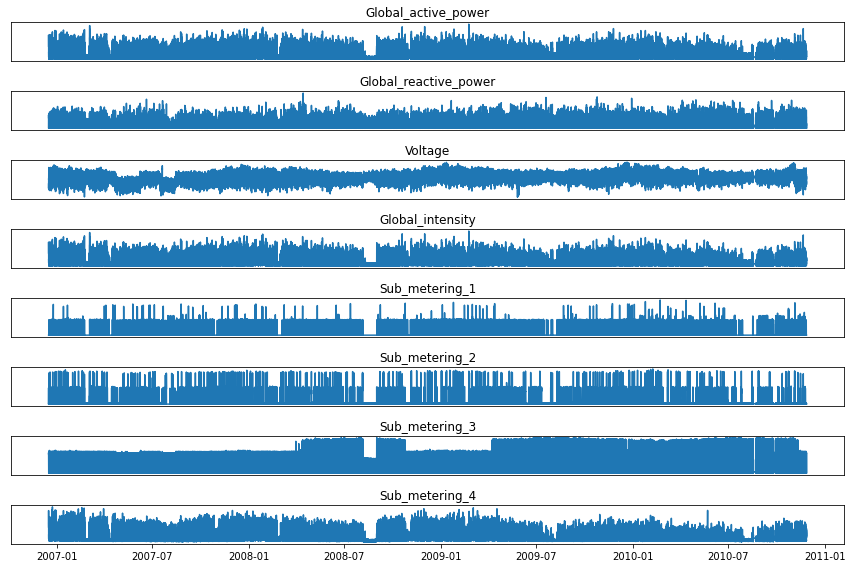

In [8]:
plt.figure(figsize=(12, 8))
for i in range(len(dataset.columns)):
    plt.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    plt.plot(dataset[name])
    plt.title(name)
    plt.yticks([])
    if i < len(dataset.columns)-1:
        plt.xticks([])
plt.tight_layout()

## 개별 변수에 대하여 분석

#### Global_active_power 를 연도별로 plot

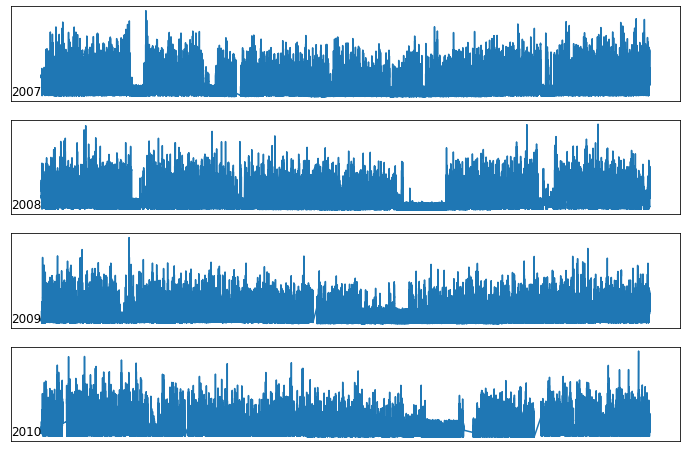

In [9]:
years = ['2007', '2008', '2009', '2010']

plt.figure(figsize=(12, 8))
for i in range(len(years)):
    ax = plt.subplot(len(years), 1, i+1)
    ax.plot(dataset.loc[years[i], 'Global_active_power'])
    ax.set_title(years[i], y=0, loc='left')
    ax.set_xticks([])
    ax.set_yticks([])

#### Global_active_power 를 특정연도(2007) 의 월별로 plot

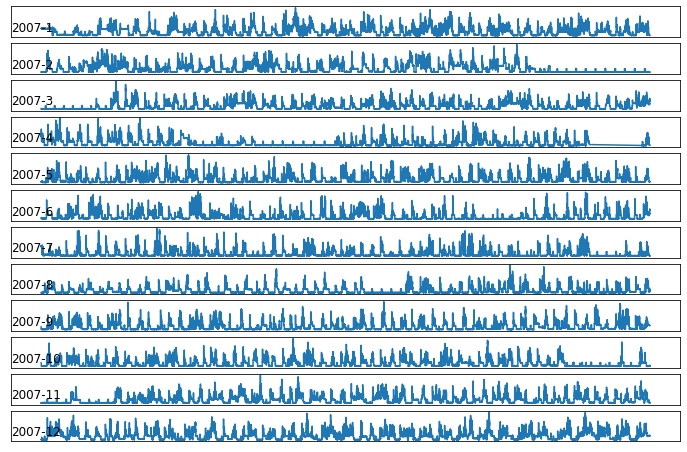

In [10]:
months = [i for i in range(1, 13)]
plt.figure(figsize=(12, 8))
for i in range(len(months)):
    ax = plt.subplot(len(months), 1, i+1)
    month = '2007-' + str(months[i])
    result = dataset.loc[month]
    ax.plot(result['Global_active_power'])
    ax.set_title(month, y=0, loc='left')
    ax.set_xticks([])
    ax.set_yticks([])

#### Global_active_power 를 특정연도(2007) 의 특정월(January)의 일별로 plot

- first 20 days

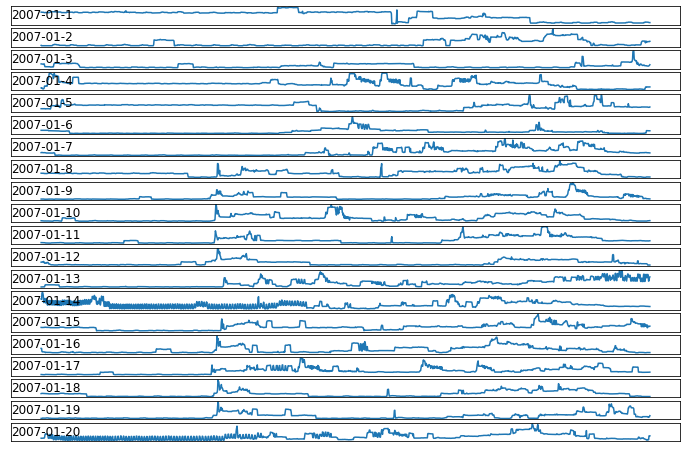

In [11]:
days = [i for i in range(1, 21)]

plt.figure(figsize=(12, 8))
for i in range(len(days)):
    ax = plt.subplot(len(days), 1, i+1)
    day = '2007-01-' + str(days[i])
    result = dataset.loc[day]
    ax.plot(result['Global_active_power'])
    ax.set_title(day, y=0, loc='left')
    ax.set_xticks([])
    ax.set_yticks([])

## Multivariate multi-step forecasting

    - next week 의 daily 사용량(global active power) 예측  
    - next month 의 daily 사용량(global active power) 예측  
    - next year 의 monthly 사용량(global active power) 예측 
    
    
- daily total 이 계산되어 있으면 편리하므로 분단위 data 를 일단위 data 로 downsampling 한다.  

- resample('D') 이용

In [12]:
daily_groups = dataset.resample('D')
daily_groups

In [13]:
daily_data = daily_groups.sum()

print(daily_data.shape)
daily_data.head()

(1442, 8)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


weekly 로 resampling 하고 싶은 경우 `W` option 사용

In [14]:
weekly_groups = dataset.resample('W')
weekly_data = weekly_groups.sum()

print(weekly_data.shape)
weekly_data.head(3)

(207, 8)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-17,4599.636,260.928,439277.85,19579.4,2033.0,4733.0,18267.0,51627.600051
2006-12-24,17477.128,1176.174,2432524.18,73992.4,11190.0,21351.0,77447.0,181297.466763
2006-12-31,19736.518,1452.334,2437971.19,83023.0,14237.0,22628.0,67237.0,224839.966614


## LSTM Multivatiate Multi-step Input and Single-step output

- next week 의 daily 사용량 예측 이므로 window_size = 7 으로 하고 `daily_data` 사용

In [15]:
daily_data.values.shape

(1442, 8)

In [16]:
d_train, d_test = daily_data.values[:-328], daily_data.values[-328:]
print(d_train.shape)
print(d_test.shape)

(1114, 8)
(328, 8)


In [17]:
sc = StandardScaler()
d_train_scaled = sc.fit_transform(d_train)
d_test_scaled = sc.transform(d_test)

input : window size 기간 내의 all features  
target : window size +1 의 `Global_active_power`

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[-1][0:1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [19]:
window_size = 7
shuffle_buffer = 10000
batch_size = 1
train_set = windowed_dataset(d_train_scaled, window_size, batch_size, shuffle_buffer)
test_set = windowed_dataset(d_test_scaled, window_size, batch_size, shuffle_buffer)
print(train_set)
print(test_set)

<PrefetchDataset shapes: ((None, None, 8), (None, 1)), types: (tf.float64, tf.float64)>
<PrefetchDataset shapes: ((None, None, 8), (None, 1)), types: (tf.float64, tf.float64)>


In [23]:
n_features = 8

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=[None, n_features]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          1312      
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        106400    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 50)                50200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 157,963
Trainable params: 157,963
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(train_set, epochs=50, verbose=2)

Epoch 1/50
1107/1107 - 25s - loss: 0.5762 - 25s/epoch - 23ms/step
Epoch 2/50
1107/1107 - 6s - loss: 0.4870 - 6s/epoch - 5ms/step
Epoch 3/50
1107/1107 - 6s - loss: 0.4456 - 6s/epoch - 5ms/step
Epoch 4/50
1107/1107 - 6s - loss: 0.4387 - 6s/epoch - 5ms/step
Epoch 5/50
1107/1107 - 6s - loss: 0.3973 - 6s/epoch - 5ms/step
Epoch 6/50
1107/1107 - 6s - loss: 0.3714 - 6s/epoch - 5ms/step
Epoch 7/50
1107/1107 - 6s - loss: 0.3560 - 6s/epoch - 5ms/step
Epoch 8/50
1107/1107 - 6s - loss: 0.3188 - 6s/epoch - 5ms/step
Epoch 9/50
1107/1107 - 6s - loss: 0.2983 - 6s/epoch - 5ms/step
Epoch 10/50
1107/1107 - 6s - loss: 0.2693 - 6s/epoch - 5ms/step
Epoch 11/50
1107/1107 - 6s - loss: 0.2508 - 6s/epoch - 5ms/step
Epoch 12/50
1107/1107 - 6s - loss: 0.2348 - 6s/epoch - 5ms/step
Epoch 13/50
1107/1107 - 6s - loss: 0.2108 - 6s/epoch - 5ms/step
Epoch 14/50
1107/1107 - 6s - loss: 0.1886 - 6s/epoch - 5ms/step
Epoch 15/50
1107/1107 - 6s - loss: 0.1778 - 6s/epoch - 5ms/step
Epoch 16/50
1107/1107 - 6s - loss: 0.1460 - 6s

In [25]:
y_test = [day[0] for day in d_test_scaled]
np.array(y_test).shape

(328,)

In [26]:
prediction = model.predict(test_set)
prediction.shape

(321, 1)

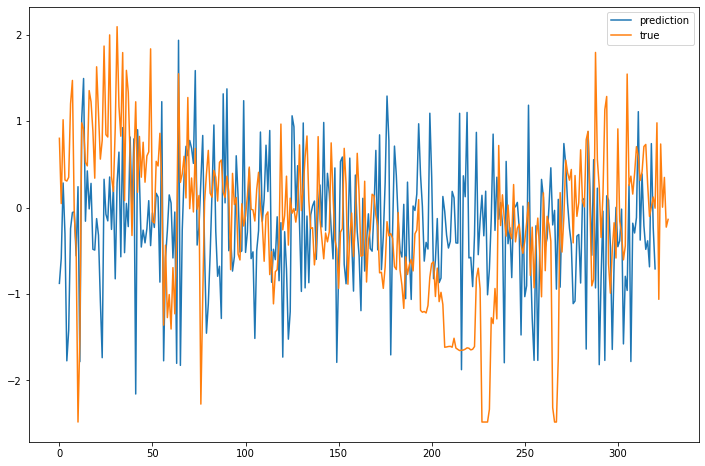

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='true')
plt.legend()

In [28]:
descaled_prediction = prediction * np.sqrt(sc.var_[0]) + sc.mean_[0]

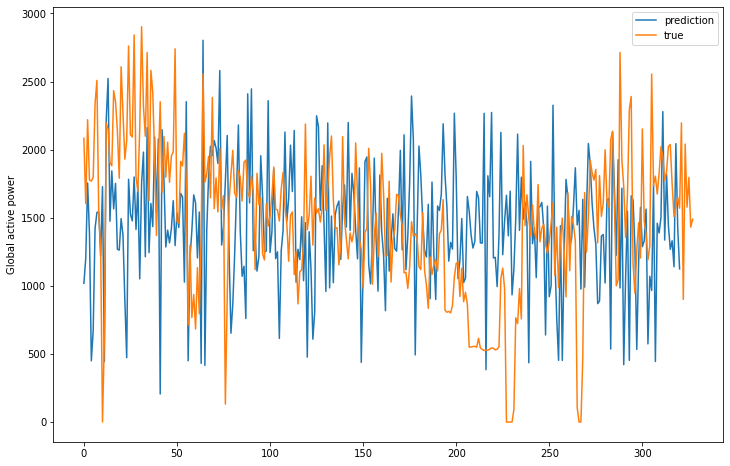

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(descaled_prediction, label='prediction')
plt.plot(d_test[:,0], label='true')
plt.ylabel('Global active power')
plt.legend()